# MobileNetV2 with MPIIFaceGaze Data

Dataset from [MPIIFaceGaze](https://collaborative-ai.org/research/datasets/MPIIFaceGaze/)

This notebook trains a gaze prediction model using a dual-input CNN:
- **Input 1**: 224×224 face image (see the other notebook for preprocessing)
- **Input 2**: 4D pupil coordinate vector (`L_Pupil` and `R_Pupil`)
- **Output**: 2D normalized gaze direction vector (from `ImageEyesGazeDirection` annotation)

We use MobileNetV2 as the backbone for the visual stream and concatenate it with pupil coordinates before regression.

In [1]:
!pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)


In [2]:
!pip install albumentations

  Using cached albumentations-2.0.7-py3-none-any.whl.metadata (43 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached stringzilla-3.12.5-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl.metadata (80 kB)
  Using cached simsimd-6.2.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (66 kB)
Using cached albumentations-2.0.7-py3-none-any.whl (367 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
Using cached simsimd-6.2.1-cp312-cp312-manylinux_2_28_x86_64.whl (633 kB)
Using cached stringzilla-3.12.5-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl (308 kB)


In [3]:
!whereis cuda

cuda: /usr/local/cuda


In [4]:
!sudo apt-get install -y cuda-compiler-12-2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cuda-cccl-12-2 cuda-crt-12-2 cuda-cudart-12-2 cuda-cudart-dev-12-2
  cuda-cuobjdump-12-2 cuda-cuxxfilt-12-2 cuda-driver-dev-12-2 cuda-nvcc-12-2
  cuda-nvprune-12-2 cuda-nvvm-12-2 cuda-toolkit-12-2-config-common
The following NEW packages will be installed:
  cuda-cccl-12-2 cuda-compiler-12-2 cuda-crt-12-2 cuda-cudart-12-2
  cuda-cudart-dev-12-2 cuda-cuobjdump-12-2 cuda-cuxxfilt-12-2
  cuda-driver-dev-12-2 cuda-nvcc-12-2 cuda-nvprune-12-2 cuda-nvvm-12-2
  cuda-toolkit-12-2-config-common
0 upgraded, 12 newly installed, 0 to remove and 0 not upgraded.
Need to get 49.8 MB of archives.
After this operation, 216 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  cuda-cccl-12-2 12.2.140-1 [1187 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/

In [1]:
import os
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/conda'

import tensorflow as tf

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

2025-05-27 18:37:45.413080: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 18:37:45.426280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748371065.443602    4840 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748371065.448930    4840 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 18:37:45.466154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence, register_keras_serializable
import albumentations as A
import random
SEED = 42028
random.seed(SEED)

## Load Dataset with Normalized Pupil Coordinates and Gaze Vectors

In [4]:
%pwd

'/home/sagemaker-user/gesture-gaze-extension/notebooks'

In [3]:
PROJ_DIR = '/home/sagemaker-user/gesture-gaze-extension'
DATA_DIR = os.path.join(PROJ_DIR, 'datasets')
IMG_DIR = os.path.join(DATA_DIR, 'MPIIFaceGazeProcessed/images')
JSON_DIR = os.path.join(DATA_DIR, 'MPIIFaceGazeProcessed/ann.json')
JSON_TRAIN_DIR = os.path.join(DATA_DIR, 'MPIIFaceGazeProcessed/ann.train.json')
JSON_VAL_DIR = os.path.join(DATA_DIR, 'MPIIFaceGazeProcessed/ann.val.json')
BEST_MODEL_PATH = os.path.join(PROJ_DIR, 'models/mobilenetv2_mpiifg_best.keras')
LAST_MODEL_PATH = os.path.join(PROJ_DIR, 'models/mobilenetv2_mpiifg_last.keras')
BEST_PRETRAIN_MODEL_PATH = os.path.join(PROJ_DIR, 'models/mobilenetv2_synth_best.keras')
LAST_PRETRAIN_MODEL_PATH = os.path.join(PROJ_DIR, 'models/mobilenetv2_synth_last.keras')
TF_SAVE_MODEL_PATH = os.path.join(PROJ_DIR, 'models/tf_mpiifg_save')
TFJS_MODEL_PATH = os.path.join(PROJ_DIR, 'models/tfjs_mpiifg_model')
IMG_SIZE = (224, 224)
INIT_LR = 1e-4

## JSON Splitting

In [7]:
#
# ONLY NEED TO RUN ONCE
#
with open(JSON_DIR, "r") as f:
    all_data = json.load(f)

train_data, val_data = train_test_split(all_data, test_size=0.2, random_state=SEED)

with open(JSON_TRAIN_DIR, "w") as f:
    json.dump(train_data, f)
with open(JSON_VAL_DIR, "w") as f:
    json.dump(val_data, f)

In [ ]:
#
# ONLY USE THIS IF YOUR COMPUTER HAVE BIG RAM
#
def load_dataset():
    with open(JSON_DIR, 'r') as f:
        data = json.load(f)

    X_img, X_pupil, y = [], [], []

    for item in data:
        img = cv2.imread(os.path.join(IMG_DIR, item['img']))
        if img is None:
            continue
        img = cv2.resize(img, (224, 224))
        img = img.astype(np.float32) / 255.0

        lp = item['l_pupil']
        rp = item['r_pupil']
        X_img.append(img)
        X_pupil.append(lp + rp)
        y.append([item['pitch'], item['yaw']])

    return np.array(X_img), np.array(X_pupil), np.array(y)


X_img, X_pupil, y = load_dataset()
X_img_train, X_img_val, X_pupil_train, X_pupil_val, y_train, y_val = train_test_split(
    X_img, X_pupil, y, test_size=0.2, random_state=SEED)

In [ ]:
print(X_pupil_train.shape)  # should be (N, 4)
print(X_img_train.shape)    # should be (N, 224, 224, 3)

## Data Augmentation

In [6]:
with open(JSON_TRAIN_DIR, "r") as f:
    train_samples = json.load(f)
with open(JSON_VAL_DIR, "r") as f:
    val_samples = json.load(f)

In [7]:
def pitchyaw_to_vector(pitch, yaw):
    x = -np.sin(yaw)
    y = -np.sin(pitch)
    return np.array([x, y])


def preprocess_from_json(sample, img_dir, image_size=224):
    img_path = tf.strings.join([img_dir, sample["img"]], separator=os.sep)

    def load_and_process(img_path_str, l_pupil, r_pupil, pitch, yaw):
        if isinstance(img_path_str, tf.Tensor):
            img_path_str = img_path_str.numpy().decode("utf-8")
        elif isinstance(img_path_str, bytes):
            img_path_str = img_path_str.decode("utf-8")
        elif isinstance(img_path_str, str):
            pass  # already OK
        else:
            raise ValueError(f"Unrecognized img_path_str type: {type(img_path_str)}")
        img = cv2.imread(img_path_str)
        img = cv2.resize(img, (image_size, image_size)).astype(np.float32) / 255.0

        # Normalize pupil positions
        l_pupil = np.array(l_pupil) / image_size
        r_pupil = np.array(r_pupil) / image_size

        gaze = pitchyaw_to_vector(pitch, yaw)
        pupil = np.concatenate([l_pupil, r_pupil]).astype(np.float32)
        return img, pupil, gaze

    def tf_wrapper(img_path, l_pupil, r_pupil, pitch, yaw):
        img, pupil, gaze = tf.py_function(
            func=load_and_process,
            inp=[img_path, l_pupil, r_pupil, pitch, yaw],
            Tout=[tf.float32, tf.float32, tf.float32]
        )
        img.set_shape((image_size, image_size, 3))
        pupil.set_shape((4,))
        gaze.set_shape((2,))
        return (img, pupil), gaze

    return tf_wrapper(
        img_path,
        sample["l_pupil"],
        sample["r_pupil"],
        sample["pitch"],
        sample["yaw"]
    )

In [8]:
class AlbumentationsGazeAugmentor:
    def __init__(self, image_size=224, vector_scale=50):
        self.image_size = image_size
        self.vector_scale = vector_scale
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=15, border_mode=cv2.BORDER_CONSTANT, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussNoise(p=0.2)
        ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    def __call__(self, img, gaze_vector, l_pupil, r_pupil):
        center = np.array([self.image_size / 2, self.image_size / 2])
        endpoint = center + gaze_vector * self.vector_scale
        keypoints = [
            tuple(center), tuple(endpoint),
            tuple([p * self.image_size for p in l_pupil]),
            tuple([p * self.image_size for p in r_pupil]),
        ]

        augmented = self.aug(image=(img * 255).astype(np.uint8), keypoints=keypoints)
        aug_img = augmented["image"].astype(np.float32) / 255.0

        new_center = np.array(augmented["keypoints"][0])
        new_endpoint = np.array(augmented["keypoints"][1])
        new_l_pupil = np.array(augmented["keypoints"][2]) / self.image_size
        new_r_pupil = np.array(augmented["keypoints"][3]) / self.image_size

        vec = new_endpoint - new_center
        norm = np.linalg.norm(vec)
        new_gaze = vec / norm if norm != 0 else gaze_vector

        return aug_img, new_gaze, new_l_pupil, new_r_pupil


class IdentityGazeAugmentor:
    def __init__(self, image_size=224, vector_scale=50):
        self.image_size = image_size
        self.vector_scale = vector_scale

    def __call__(self, img, gaze_vector, l_pupil, r_pupil):
        return img, gaze_vector, l_pupil, r_pupil

In [9]:
def get_tf_augment_wrapper(augmentor, img_dir, image_size=224):
    def tf_aug(img_path, l_pupil, r_pupil, pitch, yaw):
        def _py_aug(img_path_str, l_pupil, r_pupil, pitch, yaw):
            if isinstance(img_path_str, tf.Tensor):
                img_path_str = img_path_str.numpy().decode("utf-8")
            elif isinstance(img_path_str, bytes):
                img_path_str = img_path_str.decode("utf-8")
            elif isinstance(img_path_str, str):
                pass  # already OK
            else:
                raise ValueError(f"Unrecognized img_path_str type: {type(img_path_str)}")
            full_path = os.path.join(img_dir, img_path_str)
            img = cv2.imread(full_path)
            img = cv2.resize(img, (image_size, image_size)).astype(np.float32) / 255.0

            gaze_vec = pitchyaw_to_vector(pitch, yaw)
            aug_img, aug_gaze, aug_lp, aug_rp = augmentor(img, gaze_vec, l_pupil, r_pupil)

            pupil = np.concatenate([aug_lp, aug_rp]).astype(np.float32)
            return aug_img, pupil, aug_gaze

        img, pupil, gaze = tf.py_function(
            func=_py_aug,
            inp=[img_path, l_pupil, r_pupil, pitch, yaw],
            Tout=[tf.float32, tf.float32, tf.float32]
        )
        img.set_shape((image_size, image_size, 3))
        pupil.set_shape((4,))
        gaze.set_shape((2,))
        return (img, pupil), gaze

    return tf_aug

In [10]:
def build_dataset(samples, img_dir, batch_size=32, image_size=224, shuffle=True, augmentor=None):
    img_dir_tensor = tf.constant(img_dir)

    def gen():
        for s in samples:
            yield s

    ds = tf.data.Dataset.from_generator(
        gen,
        output_signature={
            "img": tf.TensorSpec(shape=(), dtype=tf.string),
            "l_pupil": tf.TensorSpec(shape=(2,), dtype=tf.float32),
            "r_pupil": tf.TensorSpec(shape=(2,), dtype=tf.float32),
            "pitch": tf.TensorSpec(shape=(), dtype=tf.float32),
            "yaw": tf.TensorSpec(shape=(), dtype=tf.float32),
        }
    )

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    if augmentor is not None:
        ds = ds.map(
            lambda sample: get_tf_augment_wrapper(augmentor, img_dir, image_size)(
                sample["img"],
                sample["l_pupil"],
                sample["r_pupil"],
                sample["pitch"],
                sample["yaw"]
            ),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    else:
        ds = ds.map(lambda s: preprocess_from_json(s, img_dir_tensor, image_size),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

## Define Cosine Similarity Loss for Gaze Vectors

In [11]:
@register_keras_serializable()
def cosine_loss(y_true, y_pred):
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    return 1 - tf.reduce_sum(y_true * y_pred, axis=-1)

## Add Angular Error as a Keras Metric

In [12]:
@register_keras_serializable()
def gaze_angular_error(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.math.l2_normalize(y_true, axis=-1)
    y_pred = tf.math.l2_normalize(y_pred, axis=-1)
    dot = tf.reduce_sum(y_true * y_pred, axis=-1)
    dot = tf.clip_by_value(dot, -1.0, 1.0)
    angle_rad = tf.acos(dot)
    return angle_rad * (180.0 / np.pi)  # convert to degrees

## Build the Dual-Input Gaze Prediction Model

In [13]:
def build_dual_input_model():
    img_input = Input(shape=(224, 224, 3), name='image_input')
    pupil_input = Input(shape=(4,), name='pupil_input')

    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    y = Dense(32, activation='relu')(pupil_input)

    combined = Concatenate()([x, y])
    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.3)(z)
    output = Dense(2, activation='linear', name='gaze_output')(z)

    model = Model(inputs=[img_input, pupil_input], outputs=output)
    return model


model = build_dual_input_model()
optimizer = optimizer=tf.keras.optimizers.Adam(INIT_LR)
model.compile(optimizer, loss=cosine_loss, metrics=['mae', gaze_angular_error])
model.summary()

/tmp/ipykernel_4840/1929500117.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)
I0000 00:00:1748371087.533701    4840 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,426,466 (9.26 MB)

 Trainable params: 2,392,354 (9.13 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Train

In [14]:
# LR Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # shrink LR by half
    patience=5,       # wait 5 epochs with no improvement
    cooldown=5,
    min_lr=1e-6,
    verbose=1
)

# Checkpoints
callbacks = [
    lr_scheduler,
    ModelCheckpoint(
        BEST_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ModelCheckpoint(
        LAST_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )
]

In [15]:
augmentor = AlbumentationsGazeAugmentor()
batch = 32
train_ds = build_dataset(train_samples, IMG_DIR, batch_size=batch, augmentor=augmentor)
val_ds = build_dataset(val_samples, IMG_DIR, batch_size=batch, shuffle=False, augmentor=None)

## Fine-tuning

In [ ]:
model = tf.keras.models.load_model(LAST_PRETRAIN_MODEL_PATH, custom_objects={"cosine_loss": cosine_loss})
model.optimizer.learning_rate.assign(1e-4)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)
model.export(TF_SAVE_MODEL_PATH)

Epoch 1/100


I0000 00:00:1748371188.256516    4877 service.cc:148] XLA service 0x7fa9d4003e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748371188.256543    4877 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-05-27 18:39:48.945923: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748371191.118922    4877 cuda_dnn.cc:529] Loaded cuDNN version 90800
E0000 00:00:1748371194.727713    4877 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748371194.865895    4877 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


      1/Unknown 37s 37s/step - gaze_angular_error: 75.9293 - loss: 0.8016 - mae: 9.2208

I0000 00:00:1748371209.439669    4877 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    941/Unknown 248s 225ms/step - gaze_angular_error: 38.4660 - loss: 0.3124 - mae: 16.6084

E0000 00:00:1748371426.512112    4878 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748371426.650003    4878 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


    942/Unknown 267s 245ms/step - gaze_angular_error: 38.4598 - loss: 0.3124 - mae: 16.6097

2025-05-27 18:44:00.177413: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-05-27 18:44:00.177473: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-05-27 18:44:00.177492: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656
/opt/conda/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
E0000 00:00:1748371466.171705    4876 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal 


Epoch 1: val_loss improved from inf to 0.27178, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras


2025-05-27 18:44:27.717482: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 1: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 296s 276ms/step - gaze_angular_error: 38.4536 - loss: 0.3123 - mae: 16.6110 - val_gaze_angular_error: 36.8552 - val_loss: 0.2718 - val_mae: 13.3106 - learning_rate: 1.0000e-04
Epoch 2/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 27.1734 - loss: 0.1905 - mae: 20.3628

2025-05-27 18:48:02.700365: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 2: val_loss improved from 0.27178 to 0.22465, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras


2025-05-27 18:48:23.105783: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 2: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 27.1726 - loss: 0.1905 - mae: 20.3630 - val_gaze_angular_error: 31.3875 - val_loss: 0.2247 - val_mae: 18.3314 - learning_rate: 1.0000e-04
Epoch 3/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 24.4967 - loss: 0.1629 - mae: 21.8763
Epoch 3: val_loss improved from 0.22465 to 0.19376, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras

Epoch 3: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 250ms/step - gaze_angular_error: 24.4964 - loss: 0.1629 - mae: 21.8769 - val_gaze_angular_error: 29.0505 - val_loss: 0.1938 - val_mae: 16.2569 - learning_rate: 1.0000e-04
Epoch 4/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 22.7970 - loss: 0.1478 - mae: 23.00

2025-05-27 18:56:14.619764: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 4: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 236s 250ms/step - gaze_angular_error: 22.7969 - loss: 0.1478 - mae: 23.0027 - val_gaze_angular_error: 24.6171 - val_loss: 0.1597 - val_mae: 18.1418 - learning_rate: 1.0000e-04
Epoch 5/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - gaze_angular_error: 22.3153 - loss: 0.1423 - mae: 24.0669
Epoch 5: val_loss improved from 0.15968 to 0.11481, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras

Epoch 5: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 22.3148 - loss: 0.1423 - mae: 24.0670 - val_gaze_angular_error: 20.2684 - val_loss: 0.1148 - val_mae: 18.7750 - learning_rate: 1.0000e-04
Epoch 6/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - gaze_angular_error: 20.8983 - loss: 0.1275 - mae: 24.71

2025-05-27 19:03:43.829446: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15685812190259209869
2025-05-27 19:03:43.829496: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 317941671792867514
2025-05-27 19:03:43.829549: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 6: val_loss improved from 0.11481 to 0.10982, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras

Epoch 6: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 20.8983 - loss: 0.1275 - mae: 24.7200 - val_gaze_angular_error: 19.5974 - val_loss: 0.1098 - val_mae: 18.9324 - learning_rate: 1.0000e-04
Epoch 7/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - gaze_angular_error: 20.6184 - loss: 0.1247 - mae: 25.0502
Epoch 7: val_loss did not improve from 0.10982

Epoch 7: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 234s 248ms/step - gaze_angular_error: 20.6188 - loss: 0.1248 - mae: 25.0501 - val_gaze_angular_error: 19.5088 - val_loss: 0.1146 - val_mae: 17.4098 - learning_rate: 1.0000e-04
Epoch 8/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_an

2025-05-27 19:11:53.998312: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 21.0321 - loss: 0.1296 - mae: 25.3077 - val_gaze_angular_error: 20.4137 - val_loss: 0.1129 - val_mae: 21.8438 - learning_rate: 1.0000e-04
Epoch 9/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 20.2455 - loss: 0.1221 - mae: 26.2584
Epoch 9: val_loss improved from 0.10982 to 0.09138, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras

Epoch 9: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 20.2455 - loss: 0.1221 - mae: 26.2587 - val_gaze_angular_error: 17.2669 - val_loss: 0.0914 - val_mae: 22.5245 - learning_rate: 1.0000e-04
Epoch 10/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 21.4190 - loss: 0.1340 - mae: 26.8033
Epoch 10: val_loss improved from 0.09138 to 0.08374, saving model to /home/sagemaker-user/gesture-gaze-

2025-05-27 19:42:54.265645: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 16: val_loss did not improve from 0.08374

Epoch 16: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras


2025-05-27 19:43:15.102769: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


942/942 ━━━━━━━━━━━━━━━━━━━━ 236s 250ms/step - gaze_angular_error: 17.3010 - loss: 0.0941 - mae: 28.3427 - val_gaze_angular_error: 16.2984 - val_loss: 0.0850 - val_mae: 22.8096 - learning_rate: 5.0000e-05
Epoch 17/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - gaze_angular_error: 16.5919 - loss: 0.0878 - mae: 28.0653

2025-05-27 19:46:49.258972: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 15685812190259209869
2025-05-27 19:46:49.259034: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 317941671792867514
2025-05-27 19:46:49.259083: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 17: val_loss did not improve from 0.08374

Epoch 17: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 16.5921 - loss: 0.0878 - mae: 28.0649 - val_gaze_angular_error: 17.7913 - val_loss: 0.0980 - val_mae: 21.0236 - learning_rate: 5.0000e-05
Epoch 18/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 16.4320 - loss: 0.0872 - mae: 26.9549

2025-05-27 19:50:44.622301: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 18: val_loss improved from 0.08374 to 0.07834, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras

Epoch 18: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 236s 250ms/step - gaze_angular_error: 16.4323 - loss: 0.0872 - mae: 26.9547 - val_gaze_angular_error: 15.7975 - val_loss: 0.0783 - val_mae: 19.4905 - learning_rate: 5.0000e-05
Epoch 19/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 16.6841 - loss: 0.0891 - mae: 26.3235
Epoch 19: val_loss improved from 0.07834 to 0.06994, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras

Epoch 19: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 236s 250ms/step - gaze_angular_error: 16.6838 - loss: 0.0891 - mae: 26.3236 - val_gaze_angular_error: 14.3535 - val_loss: 0.0699 - va

2025-05-27 20:46:24.720714: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


942/942 ━━━━━━━━━━━━━━━━━━━━ 234s 249ms/step - gaze_angular_error: 14.2749 - loss: 0.0685 - mae: 23.7331 - val_gaze_angular_error: 15.3094 - val_loss: 0.0745 - val_mae: 18.2575 - learning_rate: 2.5000e-05
Epoch 33/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - gaze_angular_error: 14.1864 - loss: 0.0689 - mae: 23.5607

2025-05-27 20:50:00.070731: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 33: val_loss did not improve from 0.06405

Epoch 33: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 236s 250ms/step - gaze_angular_error: 14.1865 - loss: 0.0689 - mae: 23.5607 - val_gaze_angular_error: 13.9171 - val_loss: 0.0660 - val_mae: 18.7622 - learning_rate: 2.5000e-05
Epoch 34/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - gaze_angular_error: 13.7965 - loss: 0.0640 - mae: 23.1041
Epoch 34: val_loss did not improve from 0.06405

Epoch 34: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 234s 248ms/step - gaze_angular_error: 13.7967 - loss: 0.0640 - mae: 23.1041 - val_gaze_angular_error: 16.6861 - val_loss: 0.0847 - val_mae: 18.0745 - learning_rate: 2.5000e-05
Epoch 35/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 13.8289 - loss: 0.0644 - mae: 22.9429

2025-05-27 20:57:48.975944: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 35: val_loss did not improve from 0.06405

Epoch 35: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 13.8290 - loss: 0.0644 - mae: 22.9428 - val_gaze_angular_error: 14.1216 - val_loss: 0.0676 - val_mae: 17.9144 - learning_rate: 2.5000e-05
Epoch 36/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 13.9101 - loss: 0.0658 - mae: 22.5026
Epoch 36: val_loss improved from 0.06405 to 0.05621, saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_best.keras

Epoch 36: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 236s 250ms/step - gaze_angular_error: 13.9102 - loss: 0.0658 - mae: 22.5025 - val_gaze_angular_error: 12.5349 - val_loss: 0.0562 - val_mae: 18.3231 - learning_rate: 2.5000e-05
Epoch 37/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - g

2025-05-27 21:21:19.909064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 41: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 41: val_loss did not improve from 0.05621

Epoch 41: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 234s 249ms/step - gaze_angular_error: 13.2577 - loss: 0.0604 - mae: 21.6948 - val_gaze_angular_error: 15.2376 - val_loss: 0.0780 - val_mae: 16.9753 - learning_rate: 2.5000e-05
Epoch 42/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - gaze_angular_error: 13.4723 - loss: 0.0631 - mae: 21.4296

2025-05-27 21:25:14.462111: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 42: val_loss did not improve from 0.05621

Epoch 42: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 234s 249ms/step - gaze_angular_error: 13.4723 - loss: 0.0631 - mae: 21.4296 - val_gaze_angular_error: 13.6144 - val_loss: 0.0635 - val_mae: 17.0349 - learning_rate: 1.2500e-05
Epoch 43/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 13.2310 - loss: 0.0607 - mae: 21.4470
Epoch 43: val_loss did not improve from 0.05621

Epoch 43: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 13.2311 - loss: 0.0607 - mae: 21.4470 - val_gaze_angular_error: 12.6987 - val_loss: 0.0569 - val_mae: 16.8418 - learning_rate: 1.2500e-05
Epoch 44/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - gaze_angular_error: 13.2423 - loss: 0.0611 - mae: 21.1085
Epoch 44: val_loss did not improve from 0.056

2025-05-27 21:56:33.673526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 17226827219245730656



Epoch 50: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 50: val_loss did not improve from 0.05621

Epoch 50: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 236s 250ms/step - gaze_angular_error: 12.8398 - loss: 0.0571 - mae: 19.6902 - val_gaze_angular_error: 14.2046 - val_loss: 0.0685 - val_mae: 14.9616 - learning_rate: 1.2500e-05
Epoch 51/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 12.7652 - loss: 0.0565 - mae: 19.3349
Epoch 51: val_loss did not improve from 0.05621

Epoch 51: saving model to /home/sagemaker-user/gesture-gaze-extension/models/mobilenetv2_mpiifg_last.keras
942/942 ━━━━━━━━━━━━━━━━━━━━ 235s 249ms/step - gaze_angular_error: 12.7652 - loss: 0.0565 - mae: 19.3349 - val_gaze_angular_error: 13.3952 - val_loss: 0.0632 - val_mae: 15.2200 - learning_rate: 6.2500e-06
Epoch 52/100
942/942 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - gaze_angular_error: 12.788

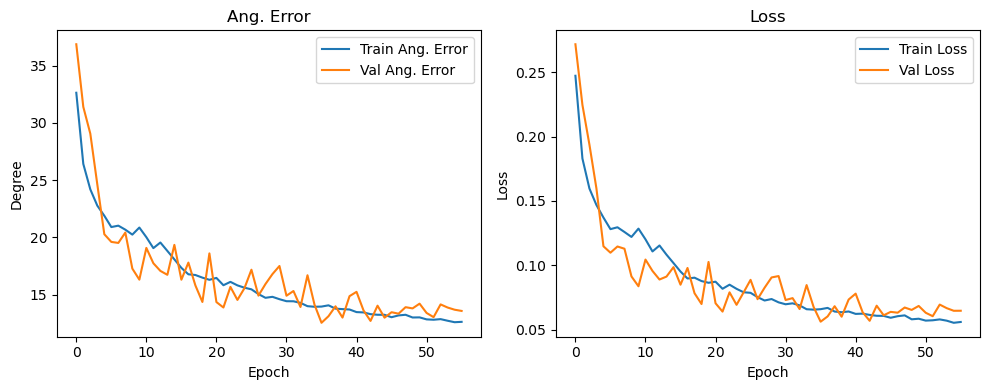

In [20]:
# 1. Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['gaze_angular_error'], label='Train Ang. Error')
    plt.plot(history.history['val_gaze_angular_error'], label='Val Ang. Error')
    plt.title('Ang. Error')
    plt.xlabel('Epoch')
    plt.ylabel('Degree')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

## Visualize Gaze Prediction on Validation Set

In [21]:
def draw_gaze_from_pupils(img, gaze_vec, l_pupil, r_pupil, color=(0, 255, 0), scale=50):
    img = img.copy()
    l_pt = (round(l_pupil[0]), round(l_pupil[1]))
    r_pt = (round(r_pupil[0]), round(r_pupil[1]))

    l_end = (round(l_pt[0] + gaze_vec[0] * scale), round(l_pt[1] + gaze_vec[1] * scale))
    r_end = (round(r_pt[0] + gaze_vec[0] * scale), round(r_pt[1] + gaze_vec[1] * scale))

    cv2.arrowedLine(img, l_pt, l_end, color, 2, tipLength=0.1)
    cv2.arrowedLine(img, r_pt, r_end, color, 2, tipLength=0.1)  # red from right eye
    return img

In [22]:
def draw_vector(img, vector, color=(0, 255, 0), scale=50):
    h, w = img.shape[:2]
    start = (w // 2, h // 2)
    end = (int(start[0] + vector[0]*scale), int(start[1] + vector[1]*scale))
    img_arrow = img.copy()
    cv2.arrowedLine(img_arrow, start, end, color, 2, tipLength=0.3)
    return img_arrow

In [23]:
best_model = tf.keras.models.load_model(BEST_MODEL_PATH, custom_objects={"cosine_loss": cosine_loss})
last_model = tf.keras.models.load_model(LAST_MODEL_PATH, custom_objects={"cosine_loss": cosine_loss})

In [40]:
def visualize_model_predictions(model, json_path, img_dir, n=10, image_size=224):
    import json
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    with open(json_path, 'r') as f:
        val_samples = json.load(f)

    for i in range(min(n, len(val_samples))):
        sample = val_samples[i]
        img_path = os.path.join(img_dir, sample["img"])

        img = cv2.imread(img_path)
        if img is None:
            continue
        img_resized = cv2.resize(img, (image_size, image_size)).astype(np.float32) / 255.0

        l_pupil = sample["l_pupil"]
        r_pupil = sample["r_pupil"]
        input_img = np.expand_dims(img_resized, axis=0)
        input_pupil = np.expand_dims(np.array(l_pupil + r_pupil), axis=0)

        pred_vec = model.predict([input_img, input_pupil], verbose=0)[0]
        pitch, yaw = sample["pitch"], sample["yaw"]
        true_vec = pitchyaw_to_vector(pitch, yaw)

        vis = draw_gaze_from_pupils((img_resized * 255).astype(np.uint8), true_vec, l_pupil, r_pupil, color=(0, 255, 0))
        vis = draw_gaze_from_pupils(vis, pred_vec, l_pupil, r_pupil, color=(0, 0, 255))

        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.title(f"Sample {i+1} — Green: GT, Red: Pred")
        plt.axis("off")
        plt.show()

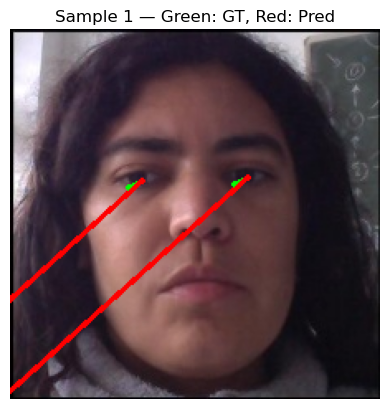

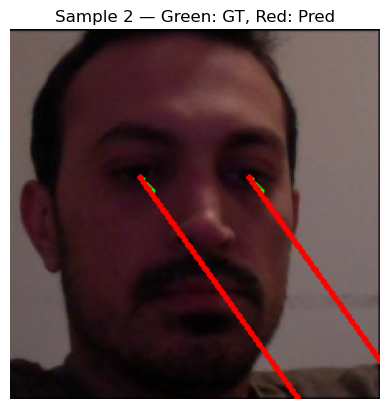

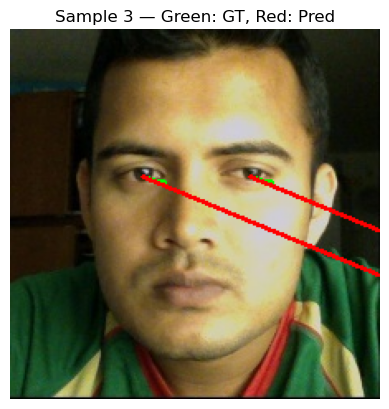

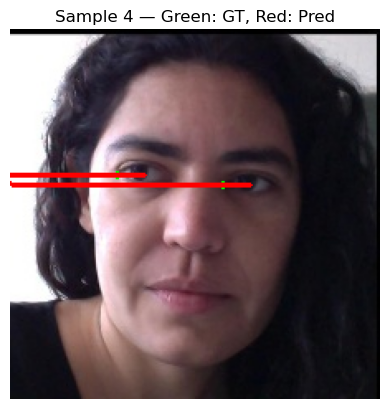

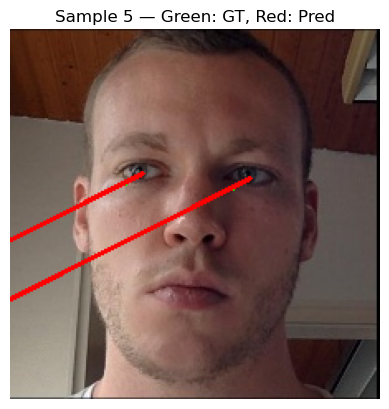

In [41]:
visualize_model_predictions(model, JSON_VAL_DIR, IMG_DIR, n=5)

In [5]:
!pip install tensorflowjs
!pip install optree==0.14.0
import tensorflowjs as tfjs
!tensorflowjs_converter --input_format=tf_saved_model $TF_SAVE_MODEL_PATH $TFJS_MODEL_PATH

  Using cached optree-0.14.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (47 kB)
Using cached optree-0.14.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (400 kB)
  Attempting uninstall: optree
    Found existing installation: optree 0.15.0
    Uninstalling optree-0.15.0:
      Successfully uninstalled optree-0.15.0
2025-05-27 22:40:30.448555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748385630.469168   13122 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748385630.474651   13122 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748385630.489351   13122 computation_placer.cc:177] computation place